In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

In [2]:
path = '/Users/jiachenyao/Desktop/Thesis/OpenFace_data/All_data_intensity_2/'

In [3]:
# Load data and extract features
dfs = []
num_deleted = 0

max_rows = 0
max_file = None

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        df = pd.read_csv(filepath)
        


        # Check the ratio of rows with confidence >= 0.98 to the total number of rows
        if len(df)>320 or len(df[df["confidence"]<0.98])/len(df) >= 0.15:
            # print the filename and delete the df variable
            #print(filename)
            del df
            num_deleted += 1
        else:
            # Select confidence >= 0.98 & success = 1
            df = df.loc[(df["confidence"]>= 0.98) & (df["success"]== 1 ) ] 
            # Drop columns that does not contain facial feature information
            df = df.drop(columns=["confidence","success","frame", "face_id", "timestamp"])
            
            # Drop binary AU features
            cols_to_drop = df.filter(regex='AU.*_c').columns
            df = df.drop(columns=cols_to_drop)

            # Feature selection
            # 115 features, excluding 3D and eye
            #df = df.iloc[:, np.concatenate([range(0, 8), range(288,294),range(299,306),range(311,321),range(325,330),
                                            #range(342,362),range(367,374),range(379,389),range(393,398),
                                            #range(410,430),range(674,691)])]

            
            # only mouth-100 features
            df = df.iloc[:, np.concatenate([range(342,362), range(410,430),range(478,498),range(546,566),range(614,634)])]
            
            # eye_lmk: 0-7, 28-35 眼珠子外圈
            # eye brow: 17-26
            # mouth: 48-67
            # 230 features
            #df = df.iloc[:, np.concatenate([range(8,16), range(36,44),range(64,72),range(92,100),range(120,128),range(148,156),
                                            
                                            #range(176,184),range(204,212),range(232,240),range(262,270), 
                                            #range(311,321),range(379,389),range(447,457),range(515,525),range(583,593), # eye brow: 17-26
                                            #range(342,362), range(410,430),range(478,498),range(546,566),range(614,634)])] ## mouth: 48-67
            
            # above all + 脸颊


            df = df.fillna(method='ffill') # Forward fill missing values
            df = df.fillna(method='bfill') # Backward fill missing values

            # Add a column to indicate the emotion
            df.insert(0, 'emotion', os.path.splitext(os.path.basename(filepath))[0])
            # Exclude actor id
            df['emotion'] = df['emotion'].str.split('_', n=1, expand=True)[1]
            
            
            num_rows = df.shape[0]
            if num_rows > max_rows:
                max_rows = num_rows
                max_file = filename
            
            dfs.append(df)
        
print(f"{num_deleted} dataframes were deleted.")
print(len(dfs))

# Print file with maximum number of rows
print("File with maximum rows:", max_file)
print("Number of rows:", max_rows)


266 dataframes were deleted.
905
File with maximum rows: A205_mix_disg_sad_3070.csv
Number of rows: 299


In [4]:
columns = dfs[1].columns.tolist()
columns

['emotion',
 'x_48',
 'x_49',
 'x_50',
 'x_51',
 'x_52',
 'x_53',
 'x_54',
 'x_55',
 'x_56',
 'x_57',
 'x_58',
 'x_59',
 'x_60',
 'x_61',
 'x_62',
 'x_63',
 'x_64',
 'x_65',
 'x_66',
 'x_67',
 'y_48',
 'y_49',
 'y_50',
 'y_51',
 'y_52',
 'y_53',
 'y_54',
 'y_55',
 'y_56',
 'y_57',
 'y_58',
 'y_59',
 'y_60',
 'y_61',
 'y_62',
 'y_63',
 'y_64',
 'y_65',
 'y_66',
 'y_67',
 'X_48',
 'X_49',
 'X_50',
 'X_51',
 'X_52',
 'X_53',
 'X_54',
 'X_55',
 'X_56',
 'X_57',
 'X_58',
 'X_59',
 'X_60',
 'X_61',
 'X_62',
 'X_63',
 'X_64',
 'X_65',
 'X_66',
 'X_67',
 'Y_48',
 'Y_49',
 'Y_50',
 'Y_51',
 'Y_52',
 'Y_53',
 'Y_54',
 'Y_55',
 'Y_56',
 'Y_57',
 'Y_58',
 'Y_59',
 'Y_60',
 'Y_61',
 'Y_62',
 'Y_63',
 'Y_64',
 'Y_65',
 'Y_66',
 'Y_67',
 'Z_48',
 'Z_49',
 'Z_50',
 'Z_51',
 'Z_52',
 'Z_53',
 'Z_54',
 'Z_55',
 'Z_56',
 'Z_57',
 'Z_58',
 'Z_59',
 'Z_60',
 'Z_61',
 'Z_62',
 'Z_63',
 'Z_64',
 'Z_65',
 'Z_66',
 'Z_67']

(array([ 4.,  7., 21., 33., 40., 44., 37., 35., 38., 38., 31., 29., 41.,
        50., 55., 41., 41., 34., 40., 40., 34., 29., 32., 36., 27., 20.,
        14., 10.,  4.,  0.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 33. ,  42.3,  51.6,  60.9,  70.2,  79.5,  88.8,  98.1, 107.4,
        116.7, 126. , 135.3, 144.6, 153.9, 163.2, 172.5, 181.8, 191.1,
        200.4, 209.7, 219. , 228.3, 237.6, 246.9, 256.2, 265.5, 274.8,
        284.1, 293.4, 302.7, 312. , 321.3, 330.6, 339.9, 349.2, 358.5,
        367.8, 377.1, 386.4, 395.7, 405. , 414.3, 423.6, 432.9, 442.2,
        451.5, 460.8, 470.1, 479.4, 488.7, 498. , 507.3, 516.6, 525.9,
        

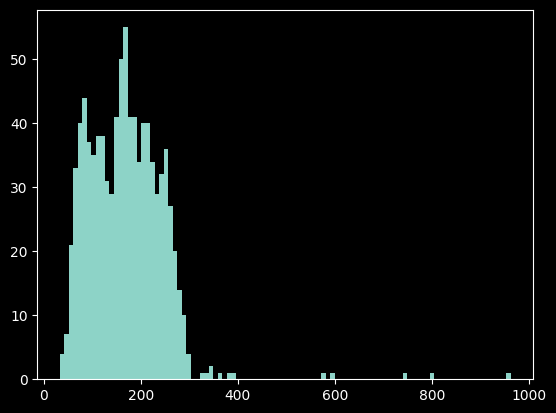

In [34]:
dfs_len = [len(df) for df in dfs]

plt.hist(dfs_len, bins=100)

In [5]:
# Normalize the data
for df in dfs:
    cols_to_normalize = df.columns.difference(['emotion'])
    df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min())) # mix-max normalization
    #df[cols_to_normalize] = df[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std()) # Z normalization

In [6]:
# change emotion name
emotions = []

for df in dfs:
    emotion = df['emotion'].unique()
    emotion = emotion[0]
    if emotion.startswith('mix'):
        emotion = emotion.rsplit("_", 1)[0]
    else:
        emotion = emotion.split("_", 1)[0]
    df['emotion'] = emotion
    emotions.append(emotion)

In [7]:
# encode labels
label_encoder = LabelEncoder()
label_list = label_encoder.fit_transform(emotions)
label_mapping = dict(zip(label_list, emotions))

emo_labels = []
for df in dfs:
    emotion = df['emotion'].iloc[0]
    label = label_encoder.transform([emotion])[0]
    emo_labels.extend([label] * len(df))

In [8]:
num_features = 100
num_files = len(dfs)

# Combine dataframes into a single tensor
data = torch.zeros((num_files, max_rows, num_features))  # 1e-6 is added to avoid log(0)
data_labels = torch.zeros((num_files, max_rows), dtype=torch.long) - 1 # -1 indicates missing values
for i, df in enumerate(dfs):
    encoded_labels = label_list[i]  # Convert non-numeric labels to numeric labels
    data[i, : df.shape[0]] = torch.tensor(df.iloc[:,1:101].values, dtype=torch.float32)  # Exclude the first column (labels)
    data_labels[i, : df.shape[0]] = torch.tensor(encoded_labels, dtype=torch.long)  # Use the encoded labels

In [79]:
# save tensors
torch.save(data,'data_100_mouth.pt')
torch.save(data_labels, 'labels_100_mouth.pt')

# Load data and label tensors from the directory
#data = torch.load( 'data.pt')
#labels = torch.load('labels.pt')


In [17]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, data_labels, test_size=0.2, random_state=42)

In [18]:
# Create custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels[:, 0]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [19]:
# load dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
complete_dataset = CustomDataset(data, data_labels)

# load dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
complete_loader = DataLoader(complete_dataset, batch_size=32, shuffle=True)

In [39]:
data.shape

torch.Size([905, 299, 230])

In [20]:
class TimeDistributed(nn.Module):
    def __init__(self, module: nn.Module, batch_first: bool = True):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [26]:
class TimeVAE_base(nn.Module):
    def __init__(self, latent_dim):
        super(TimeVAE_base, self).__init__()
        # encoder layers
        self.encoder_convs = nn.Sequential(
            nn.Conv1d(299, 128, 3, stride=2, padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv1d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.ReLU(True),
        
        ) # output shape: (batch_size, 64, 25)
        self.fc1 = nn.Linear(25*64, 512)
        self.mean = nn.Linear(512, latent_dim)
        self.var = nn.Linear(512, latent_dim)

        # decoder layers
        self.fc2 = nn.Linear(latent_dim, 512)
        self.fc3 = nn.Linear(512, 25*64)
        self.decoder_convs = nn.Sequential(
            nn.ConvTranspose1d(64, 128, 3, stride=2, padding=1,output_padding=1,bias=False),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 299, 3, stride=2, padding=1,output_padding=1,bias=False),
            nn.ReLU(True)
        ) # output shape: (batch_size, 963, 288)

        self.time_distributed = TimeDistributed(nn.Linear(100, 100))
        
    def encode(self, x):
        x = self.encoder_convs(x)
        x = x.contiguous().view(x.size(0), -1) # flatten
        x = self.fc1(x)
        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var
    
    def reparaterize(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def decode(self, z):
        z = self.fc2(z)
        z = self.fc3(z)
        z = z.contiguous().view(-1, 64, 25) # reshape
        z = self.decoder_convs(z)
        z = self.time_distributed(z)
        return z
    
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparaterize(mean, log_var)
        return self.decode(z), mean, log_var

In [27]:
# VAE loss function
def vae_loss(x, x_recon, mean, log_var, beta=1):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return recon_loss + kl_loss * beta

In [28]:
# Initialize the VAE model, optimizer, and other settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 10
model = TimeVAE_base(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 50

In [29]:
def train_test_vae(epochs, complete_loader, model, optimizer):
    loss_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_data, _ in tqdm(complete_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = model(batch_data)
            loss = vae_loss(batch_data, x_recon, mean, log_var, beta=2) # beta_VAE
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loss_history.append(loss.item())
        train_loss /= len(complete_loader.dataset)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}')


    # plot the training loss curve
    plt.plot(loss_history)
    plt.xlabel('Iterations')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Curve')
    plt.xlim((2,50)) 
    plt.show()


100%|██████████| 29/29 [00:01<00:00, 15.92it/s]


Epoch 1, Train Loss: 0.0075


100%|██████████| 29/29 [00:01<00:00, 18.07it/s]


Epoch 2, Train Loss: 0.0051


100%|██████████| 29/29 [00:01<00:00, 19.49it/s]


Epoch 3, Train Loss: 0.0034


100%|██████████| 29/29 [00:01<00:00, 20.41it/s]


Epoch 4, Train Loss: 0.0027


100%|██████████| 29/29 [00:01<00:00, 19.97it/s]


Epoch 5, Train Loss: 0.0026


100%|██████████| 29/29 [00:01<00:00, 18.38it/s]


Epoch 6, Train Loss: 0.0026


100%|██████████| 29/29 [00:01<00:00, 19.87it/s]


Epoch 7, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.80it/s]


Epoch 8, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.66it/s]


Epoch 9, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.78it/s]


Epoch 10, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


Epoch 11, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.19it/s]


Epoch 12, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.10it/s]


Epoch 13, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.60it/s]


Epoch 14, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.40it/s]


Epoch 15, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.77it/s]


Epoch 16, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.98it/s]


Epoch 17, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.09it/s]


Epoch 18, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.91it/s]


Epoch 19, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.25it/s]


Epoch 20, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.10it/s]


Epoch 21, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.49it/s]


Epoch 22, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.04it/s]


Epoch 23, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.94it/s]


Epoch 24, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.93it/s]


Epoch 25, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.54it/s]


Epoch 26, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.64it/s]


Epoch 27, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.82it/s]


Epoch 28, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.19it/s]


Epoch 29, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.60it/s]


Epoch 30, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.67it/s]


Epoch 31, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.81it/s]


Epoch 32, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.14it/s]


Epoch 33, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.90it/s]


Epoch 34, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 17.56it/s]


Epoch 35, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 17.16it/s]


Epoch 36, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.02it/s]


Epoch 37, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.03it/s]


Epoch 38, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 17.87it/s]


Epoch 39, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 17.96it/s]


Epoch 40, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.68it/s]


Epoch 41, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.99it/s]


Epoch 42, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 19.62it/s]


Epoch 43, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.42it/s]


Epoch 44, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.17it/s]


Epoch 45, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.38it/s]


Epoch 46, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 18.96it/s]


Epoch 47, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.36it/s]


Epoch 48, Train Loss: 0.0025


100%|██████████| 29/29 [00:01<00:00, 20.13it/s]


Epoch 49, Train Loss: 0.0024


100%|██████████| 29/29 [00:01<00:00, 19.82it/s]


Epoch 50, Train Loss: 0.0025


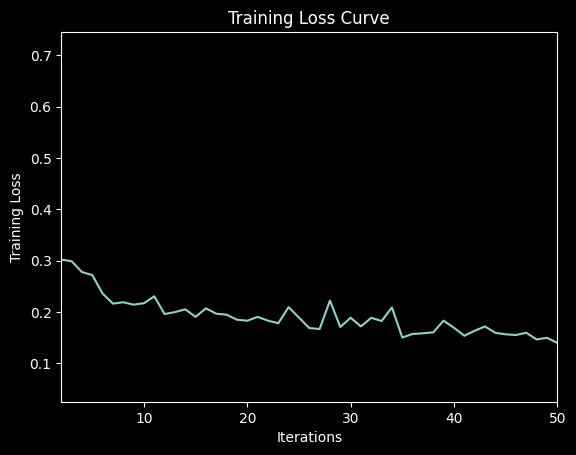

In [30]:
train_test_vae(epochs, complete_loader, model, optimizer)

In [31]:
def extract_latent_space(vae, data_loader):
    latent_space = []
    labels = []

    vae.eval()
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            batch_data = batch_data.to(device)
            mean, log_var = vae.encode(batch_data)
            z = vae.reparaterize(mean, log_var)
            latent_space.append(z.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.vstack(latent_space), labels

In [32]:
# Extract latent space from the validation dataset
latent_space, labels = extract_latent_space(model, complete_loader)


# Check dimensions
print("Shape of latent_space:", latent_space.shape)
print("Shape of labels:", len(labels))
print("Unique labels:", np.unique(labels))


Shape of latent_space: (905, 10)
Shape of labels: 905
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [33]:
# Use t-SNE to reduce the 10D latent space into a 3D space
tsne = TSNE(n_components=3, random_state=42)
latent_tsne = tsne.fit_transform(latent_space)



/var/folders/h4/3nv1jvkx1yl21fmm86sb8ggh0000gn/T/ipykernel_87221/1614576910.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(latent_tsne[labels==label, 0], latent_tsne[labels==label, 1], label=label_mapping[label],c=cmap(idx))


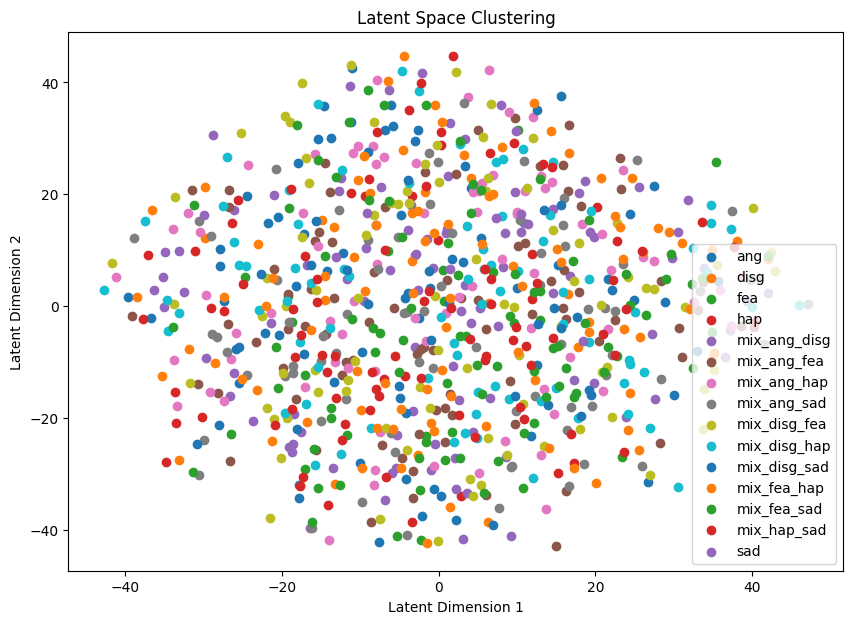

In [34]:
# Plot latent space
colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
               'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',] * 2

cmap = ListedColormap(colors_list)

plt.style.use('default')
plt.figure(figsize=(10, 7))
for idx,label in enumerate(np.unique(labels)):
    plt.scatter(latent_tsne[labels==label, 0], latent_tsne[labels==label, 1], label=label_mapping[label],c=cmap(idx))
plt.legend()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

plt.title('Latent Space Clustering')
plt.show()

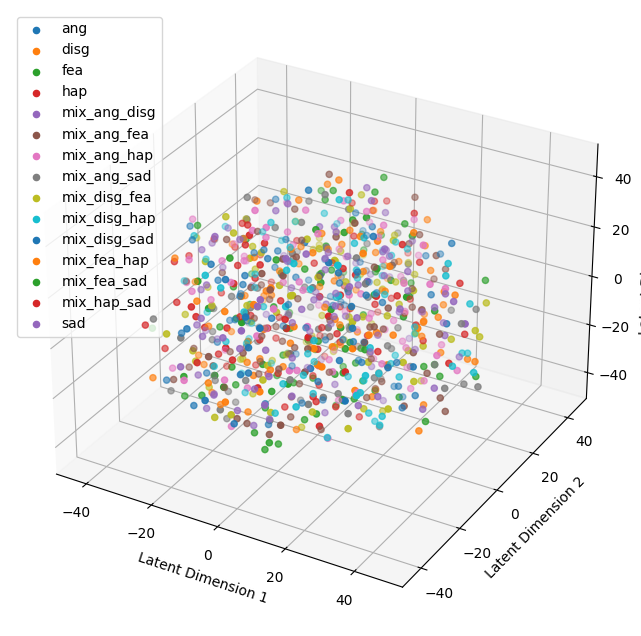

In [35]:
# 3D plot
fig_3d = plt.figure(figsize=(8, 8))
ax = fig_3d.add_subplot(111, projection='3d')

for label in np.unique(labels):
    ax.scatter(latent_tsne[labels==label, 0], latent_tsne[labels==label, 1], latent_tsne[labels==label,2],label=label_mapping[label])

ax.legend()
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.show()


In [ ]:
m = nn.Sequential(
            nn.Conv1d(277, 128, 3, stride=2, padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv1d(128, 64, 3, stride=2, padding=1, bias=False),
            nn.ReLU(True),
        
        )
input = torch.randn(32, 277, 288)



